VERBETEREN in DSS MODULE:
    

te verbeteren:

suffix matcht niet met echte uitgang e.g. MV<W ('MV</', 'subs', 'NA', 'NA') ('MV<W', 'pl', 'a', 'J', 'NA', 'pl', 'm') MV<W

Wat is hier aan de hand? XPYJ ('XPY/', 'subs', 'NA', 'NA') ('XPYJ', 'NA', 'NA', '-', 'NA', 'NA', 'm')

strange case: lex: 'RWX/' g_cons: '>RJH'

Solve issues like this: In general there is no mater counted here. ('CMJM/', 'CMJMH'): {'J': 1}

How can 'JWM/' have NA as number?
                                                                                                                           
CHECK MANUALLY: IS THERE RELEVANT VARIATION IN JWM/ ?                                                                                                              

https://ericmjl.github.io/Network-Analysis-Made-Simple/

Stanford videos van Jure Leskovic:
https://www.youtube.com/watch?v=JAB_plj2rbA&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn

1. Make text_corpus_bib_dss and text_corpus_non_bib_dss
2. Collect all lexemes in manuscripts of Isaiah
3. Collect alternative spellings of lexemes
4. Select relevant lexemes (common nouns)
5. Mask suffixes, extract matres counts from relevant lexemes 
6. Make list of lexemes with multiple representations
7. Collect lexemes from scrolls, and get their matres counts
8. Compare all matres counts of all selected lexemes between manuscripts
9. Build graph

In [1]:
import collections
from pprint import pprint
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bib_booknames_bhsa_dss import book_dict_bhsa_dss, book_dict_dss_bhsa

In [237]:
from tf.app import use
A = use('etcbc/dss:clone', checkout='clone', version='1.2', provenanceSpec=dict(moduleSpecs=[]), hoist=globals())

# give the relevant classes for the DSS new names
Ldss = L
Tdss = T
Fdss = F

This is Text-Fabric 9.2.4
Api reference : https://annotation.github.io/text-fabric/tf/cheatsheet.html

66 features found and 0 ignored


In [3]:
from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

This is Text-Fabric 9.2.4
Api reference : https://annotation.github.io/text-fabric/tf/cheatsheet.html

122 features found and 0 ignored


In [4]:
RELEVANT_MATRES = ['J', '>', 'W'] # other possibilities: 'H', '<'

In [5]:
class Character:
    def __init__(self, tf_word_id, consonant, g_cons, lex, tf_sign_id, index_in_word, index_in_verse, reconstructed):
        self.tf_word_id = tf_word_id
        self.consonant = consonant
        self.g_cons = g_cons
        self.lex = lex
        self.tf_sign_id = tf_sign_id
        self.index_in_word = index_in_word
        self.index_in_verse = index_in_verse
        self.reconstructed = reconstructed
        
class Word:
    def __init__(self, tf_word_id, bo, ch, ve, g_cons, lex, 
                 sp, person, number, gender, state, vs, vt, lang,
                 rec_signs, suffix_str=None):
        self.tf_word_id = tf_word_id
        self.bo = bo
        self.ch = ch
        self.ve = ve
        self.g_cons = g_cons
        self.lex = lex
        self.sp = sp
        self.person = person
        self.number = number
        self.gender = gender
        self.state = state
        self.vs = vs
        self.vt = vt
        self.lang = lang
        self.rec_signs = rec_signs
        self.suffix_str = suffix_str
        
        
class Verse:
    def __init__(self, manuscript, bo, ch, ve):
        self.manuscript = manuscript
        self.bo = bo
        self.ch = ch
        self.ve = ve
        self.string_sequence = ''
        self.characters = []
        self.words = []
        self.alignments = {}
    
    def __str__(self):
        return f'{self.manuscript} {self.bo} {self.ch} {self.ve}'        

class Scroll:
    def __init__(self, scroll_name):
        self.scroll_name = scroll_name
        self.verses = {}
        self.words = []
        
class TextCorpus:
    def __init__(self, corpus):
        self.corpus = corpus
        self.scrolls = {}
        
        

In [6]:
def disambiguate_sin_shin(glyphs):
    # the consonant '#' is used for both 'C' and 'F'. We check in the lexeme
    # to which of the two alternatives it should be converted. This appproach is crude, 
    # but works generally well. There is only one word with both F and C in the lexeme: 
    # >RTX##T> >AR:T.AX:CAF:T.:> in 4Q117
    if '#' in glyphs:  
        # hardcode the single word with both 'C' and 'F' in the lexeme.
        if glyphs == '>RTX##T>':
            glyphs = '>RTXCFT>'
                    
        elif 'F' in lexeme:
            glyphs = glyphs.replace('#', 'F')
                    
        # cases in wich 'C' occurs in lexeme or morphology
        else:                        
            glyphs = glyphs.replace('#', 'C')
            
    return glyphs

In [7]:
nu_suff_dict = {None: 'NA', 'p': 'pl', 's': 'sg'}
gn_suff_dict = {None: 'NA', 'c': 'unknown', 'f': 'f', 'm': 'm'}
ps_suff_dict = {None: 'NA', '1': 'p1', '2': 'p2', '3': 'p3'}

In [8]:
def get_suffix_properties(w, nu_suff_dict, gn_suff_dict, ps_suff_dict):
    nu_suff, gn_suff, ps_suff = Fdss.nu2.v(w), Fdss.gn2.v(w), Fdss.ps2.v(w)
    nu_suff = nu_suff_dict[nu_suff]
    gn_suff = gn_suff_dict[gn_suff]
    ps_suff = ps_suff_dict[ps_suff]
            
    return nu_suff, gn_suff, ps_suff

In [9]:
def process_suffixes(suffix_properties, glyphs):
    
    if suffix_properties == ('NA', 'NA', 'NA'):
        suffix = '-'
    elif suffix_properties == ('sg', 'unknown', 'p1'):
        if glyphs.endswith('J'):
            suffix = 'J'
        elif glyphs.endswith('J>'):
            suffix = 'J>'
    elif suffix_properties == ('pl', 'unknown', 'p1'):
        suffix = 'NW'
    elif suffix_properties == ('sg', 'f', 'p2'):
        if glyphs.endswith('K'):
            suffix = 'K'
        elif glyphs.endswith('KH'):
            suffix = 'KH'
        elif glyphs.endswith('KJ'):
            suffix = 'KJ'
    elif suffix_properties == ('pl', 'f', 'p2'):
        if glyphs.endswith('KN'):
            suffix = 'KN'
    elif suffix_properties == ('sg', 'm', 'p2'):
        if glyphs.endswith('K'):
            suffix = 'K'
        elif glyphs.endswith('KH'):
            suffix = 'KH'
    elif suffix_properties == ('sg', 'f', 'p3'):
        if glyphs.endswith('H'):
            suffix = 'H'
        elif glyphs.endswith('H>'):
            suffix = 'H>' 
    elif suffix_properties == ('sg', 'm', 'p3'):
        if glyphs.endswith('HW'):
            suffix = 'HW'
        elif glyphs.endswith('HWW'):
            suffix = 'HWW'
        elif glyphs.endswith('WW'):
            suffix = 'WW'
        elif glyphs.endswith('W'):
            suffix = 'W'
        elif glyphs.endswith('W>'):
            suffix = 'W>'
        elif glyphs.endswith('HJ'):
            suffix = 'HJ'
        elif glyphs.endswith('WH'):
            suffix = 'WH'
        elif glyphs.endswith('H'):
            suffix = 'H'
    elif suffix_properties == ('pl', 'm', 'p2'):
        if glyphs.endswith('KM'):
            suffix = 'KM'
        elif glyphs.endswith('KMH'):
            suffix = 'KMH'
    elif suffix_properties == ('pl', 'f', 'p3'):
        if glyphs.endswith('HNH'):
            suffix = 'HNH'    
        elif glyphs.endswith('HN'):
            suffix = 'HN'     
        elif glyphs.endswith('N'):
            suffix = 'N'
    elif suffix_properties == ('pl', 'm', 'p3'):
        if glyphs.endswith('HMH'):
            suffix = 'HMH'
        elif glyphs.endswith('HMNH'):
            suffix = 'HMNH'
        elif glyphs.endswith('HM'):
            suffix = 'HM' 
        elif glyphs.endswith('MW'):
            suffix = 'MW' 
        elif glyphs.endswith('M'):
            suffix = 'M'
        elif glyphs.endswith('MH'):  
            suffix = 'MH'
            
    return suffix
                    

In [10]:
all_bib_scrolls_dict = collections.defaultdict(lambda: collections.defaultdict(list))
all_non_bib_scrolls_dict = collections.defaultdict(list)

for scr in Fdss.otype.s('scroll'):
    scroll_name = Tdss.scrollName(scr)
    
    words = Ldss.d(scr, 'word')

        
    for w in words:
            
        dss_book = Fdss.book.v(w)
        bhsa_book = book_dict_dss_bhsa.get(dss_book, '')
        
        # check the values of chapter_num: if it starts with 'f', it is a fragment, maybe exclude?!
        chapter_num = Fdss.chapter.v(w)
        if not chapter_num:
            chapter_num = ''
            
        verse_num = Fdss.verse.v(w)
        if not verse_num:
            verse_num = ''
        
        # Do a bit of preprocessing
        if Fdss.glyphe.v(w) != None:
            lexeme = Fdss.lex_etcbc.v(w)
            lex_abegg = Fdss.lexe.v(w)
            
            glyphs = ''.join(Fdss.glyphe.v(w).split()) # remove whitespace in word
            if not glyphs:
                continue
            
            signs = Ldss.d(w, 'sign')
            # Feature rec has two values: 1 and None. None is converted to 0, then make string of all recs in one word
            reconstructed_signs = ''.join([str(Fdss.rec.v(s)) if Fdss.rec.v(s) == 1 else '0' for s in signs])
            
            # dummy value
            if lexeme == None:
                lexeme = 'XXX'
            
            glyphs = disambiguate_sin_shin(glyphs)                       
            
            # Some characters are removed or replaced, in the case of 'k', 'n', 'm', 'y', 'p', it concerns final consonants of words.
            glyphs = glyphs.replace(u'\xa0', u' ').replace('k', 'K').replace('n', 'N').replace('m', 'M').replace('y', 'Y').replace('p', 'P')   
            
            pronom_suffix_from_glyphe = '-'
            if "'" in glyphs:
                pronom_suffix_from_glyphe = glyphs.split("'")[1]
            glyphs_no_pronominal_suffix_marker = glyphs.replace("'", '')
            

            sp = Fdss.sp_etcbc.v(w)
            number = Fdss.nu_etcbc.v(w)
            person = Fdss.ps_etcbc.v(w)
            gender = Fdss.gn_etcbc.v(w)
            if gender not in {'m', 'f'}:
                gender = 'NA'
            
            
            state = Fdss.st.v(w)
            if state is None:
                state = 'NA'
            
            vs = Fdss.vs_etcbc.v(w)
            vt = Fdss.vt_etcbc.v(w)
            
            dss_lang = Fdss.lang.v(w)
            if dss_lang is None:
                lang = 'Hebrew'
            elif dss_lang == 'a':
                lang = 'Aramaic'
            elif dss_lang == 'g':
                lang = 'Greek'
                
            suffix = pronom_suffix_from_glyphe

            #print(lexeme, dss_lang)       
            word_object = Word(w, bhsa_book, chapter_num, verse_num, glyphs_no_pronominal_suffix_marker, 
                               lexeme, sp, person, number, gender, state, vs, vt, lang, reconstructed_signs, suffix)
            
            if bhsa_book:
                all_bib_scrolls_dict[scroll_name][(bhsa_book, chapter_num, verse_num)].append(word_object)
                
            else:
                all_non_bib_scrolls_dict[scroll_name].append(word_object)
            

## Add non-biblical DSS to text corpus object

In [11]:
text_corpus_non_bib_dss = TextCorpus('non_biblical_dss')

for scroll_name, word_objects in all_non_bib_scrolls_dict.items():
    
    scroll = Scroll(scroll_name)
    text_corpus_non_bib_dss.scrolls[scroll_name] = scroll
    scroll.words = words
        
    text_corpus_non_bib_dss.scrolls[scroll_name] = scroll 

## Add biblical DSS to text corpus object

In [12]:
text_corpus_bib_dss = TextCorpus('biblical_dss')

for scroll_name, verse_data in all_bib_scrolls_dict.items():
    
    scroll = Scroll(scroll_name)
    text_corpus_bib_dss.scrolls[scroll_name] = scroll
    
    for section, word_objects in verse_data.items():
        bo, ch, ve = section
        verse = Verse(scroll_name, bo, ch, ve)
        verse.words = word_objects
        scroll.verses[(bo, int(ch), int(ve))] = verse
            
    text_corpus_bib_dss.scrolls[scroll_name] = scroll

## Add BHSA to text corpus.

In [13]:
scroll = Scroll('L')
text_corpus_bib_dss.scrolls['L'] = scroll

for bo in F.otype.s('book'):

    verses = L.d(bo, 'verse')
    
    for v in verses:
        
        bo, ch, ve = T.sectionFromNode(v)
        verse = Verse('L', bo, ch, ve)
        words = L.d(v, 'word')
        
        verse.string_sequence = ''.join(([''.join([F.g_cons.v(w), F.trailer.v(w)]) if F.trailer.v(w) in {'', ' '} else F.g_cons.v(w) + ' ' 
                     for w in words])).strip()

        char_index_in_verse = 0
        
        for w in words:
            g_cons = F.g_cons.v(w)
            lexeme = F.lex.v(w)
            sp = F.sp.v(w)
            number = F.nu.v(w)
            person = F.ps.v(w)
            gender = F.gn.v(w)
            if gender not in {'m', 'f'}:
                gender = 'NA'
            state = F.st.v(w)
            
            vs = F.vs.v(w)
            vt = F.vt.v(w)
            lang = F.language.v(w)
            
            nu_suff, gn_suff, ps_suff = F.prs_nu.v(w), F.prs_gn.v(w), F.prs_ps.v(w)
            suffix_properties = (nu_suff, gn_suff, ps_suff)
            suffix = F.prs.v(w).strip('=')
            
            if suffix in {"absent", "n/a"}:
                suffix = "-"
            
            reconstructed_signs = ''.join(['0' for char in g_cons])
            
            word = Word(w, bo, ch, ve, g_cons, lexeme, sp, person, number, gender, state, vs, vt, lang, reconstructed_signs, suffix)
            verse.words.append(word)
            
        scroll.verses[(bo, int(ch), int(ve))] = verse
            
       

## Collect all lexemes in manuscripts of Isaiah

In [14]:
isa_scrolls = ['1Qisaa', '1Q8', '4Q55', '4Q56', '4Q57', '4Q58', '4Q59', '4Q60',
               '4Q61', '4Q62', '4Q62a', '4Q63', '4Q64', '4Q65', '4Q66', '4Q67',
               '4Q68', '4Q69', '4Q69a', '4Q69b', '5Q3', 'Mur3', 'L']

In [72]:
isa_lexemes = set()

for section, verse_obj in text_corpus_bib_dss.scrolls['L'].verses.items():
    for scroll_name in isa_scrolls:
        
        if section in text_corpus_bib_dss.scrolls[scroll_name].verses:
            verse_obj = text_corpus_bib_dss.scrolls[scroll_name].verses[section]
            for word in verse_obj.words:
                if word.bo == 'Isaiah' and word.sp == 'subs' and word.lex[-1] == '/':
                    isa_lexemes.add(word.lex)

## Collect alternative spellings of lexemes in dictionary

In [73]:
class SuffixMasker:
    """
    Masks plural and construct markers.
    These also have matres that should not count in the 
    """
    
    def __init__(self, g_cons, suffix, num, state):
        self.g_cons = g_cons
        self.suffix = suffix
        self.num = num
        self.state = state
        
    @staticmethod
    def _replace_suffix(word, suffix, replacement):
   
        if word.endswith(suffix):
            new_word = word[:word.rfind(suffix)] + replacement
        else:
            new_word = word
        return new_word
    
    def mask_suffixes(self):
    
        masked_word = self._replace_suffix(self.g_cons, self.suffix, 's')
            
        # Mask masc plural marker 'JM' and fem marker 'WT'
        if self.num == 'pl' or self.num == 'du':
            masked_word = self._replace_suffix(masked_word, 'JM', 'm')
            masked_word = self._replace_suffix(masked_word, 'WT', 'f')  
            masked_word = self._replace_suffix(masked_word, 'Js', 'cs')
    
        # Mask construct -J
        if masked_word.endswith('J') and self.state == 'c' and self.num in {'pl', 'du'}:
            masked_word = self._replace_suffix(masked_word, 'J', 'c')
                
        # Mask fem plural marker before s and cs ('WTcs' and 'WTs')
        if nu == 'pl' and masked_word.endswith('WTs'):
            masked_word = self._replace_suffix(masked_word, 'WTs', 'fs')
        if nu == 'pl' and masked_word.endswith('WTcs'):
            masked_word = self._replace_suffix(masked_word, 'WTcs', 'fcs')
    
        return masked_word        

In [74]:
class CharacterProcessor:
    """
    
    """
    def __init__(self, stable_chars):
        self.stable_chars = stable_chars
    
    def _convert_characters(self, g_cons):
        cons_list = list(g_cons)
        converted_chars_list = [char if char in self.stable_chars else 'y' for char in cons_list]
        converted_g_cons = ''.join(converted_chars_list)
        return converted_g_cons
    
    def _create_monograms(self, chars):
        return set(chars)

    def _create_bigrams(self, chars):
        bigram_set = set()
        if len(chars) > 1:
            for i in range(len(chars)-1):
                bigram_set.add((chars[i:i+2]))
        return bigram_set
    
    def _count_chunks(self, chars, chunks):
        chunk_counts = collections.defaultdict(int)
        for chunk in chunks:
            chunk_count = chars.count(chunk)
            chunk_counts[chunk] = chunk_count
        return chunk_counts
    
    def preprocess_characters(self, g_cons):
        converted_characters = self._convert_characters(g_cons)
        monograms_set = self._create_monograms(converted_characters)
        bigrams_set = self._create_bigrams(converted_characters)
        all_chunks_set = set.union(monograms_set, bigrams_set)
        chunk_counts = self._count_chunks(converted_characters, all_chunks_set)
        return all_chunks_set, chunk_counts
    

In [75]:
def filter_chunks(chunks, sign):
    """
    Removes chunks that are not needed, generally chunks containing 'y'
    """
    filtered_chunks = set(ch for ch in chunks if sign not in ch)
    return filtered_chunks

def filter_chunks_dict(chunks_dict, sign):
    """
    Removes keys that are not needed, generally chunks containing 'y'
    """
    filtered_chunks_dict = {k:v for k,v in chunks_dict.items() if sign not in k}
    return filtered_chunks_dict

def reduce_chunk_counts(chunk_counts_dict):
    """
    Input: dict with counts of monograms and bigrams
    Output: dict with counts of monograms and bigrams,
    but subtracts counts of monograms that are in bigram already
    """
    reduced_chunk_counts = chunk_counts_dict.copy()
    
    for key, count in chunk_counts_dict.items():
        if len(key) == 2:
            for char in key:
                single_char_count_original = chunk_counts_dict.get(char, 0)
                reduced_chunk_counts[char] -= 1
                
    reduced_chunk_counts_no_zero_values = {k:v for k,v in reduced_chunk_counts.items() if v > 0}
    
    return reduced_chunk_counts_no_zero_values

In [76]:
char_processor = CharacterProcessor(RELEVANT_MATRES)

char_processor.preprocess_characters('JRWCLJM')

({'J', 'Jy', 'W', 'Wy', 'y', 'yJ', 'yW', 'yy'},
 defaultdict(int,
             {'Wy': 1,
              'Jy': 2,
              'W': 1,
              'yy': 1,
              'yW': 1,
              'y': 4,
              'J': 2,
              'yJ': 1}))

In [77]:
all_bib_scrolls = []

for scroll_name in text_corpus_bib_dss.scrolls.keys():
    all_bib_scrolls.append(scroll_name)

In [78]:
chunks_count_dict = collections.defaultdict(set)
mono_bi_grams_set = set()


for section, verse_obj in text_corpus_bib_dss.scrolls['L'].verses.items():
    for scroll_name in all_bib_scrolls:
        
        if section in text_corpus_bib_dss.scrolls[scroll_name].verses:
            verse_obj = text_corpus_bib_dss.scrolls[scroll_name].verses[section]
            for word in verse_obj.words:
                if word.lex in isa_lexemes and word.lang == 'Hebrew' and '1' not in word.rec_signs:                        
                    
                    lex = word.lex
                    g_cons = word.g_cons
                    suff = word.suffix_str
                    nu = word.number
                    state = word.state
                    
                    word_info = (word.lex, word.number)
                    
                    masker = SuffixMasker(g_cons, suff, nu, state)
                    masked_word = masker.mask_suffixes()
                    chunks, chunk_counts = char_processor.preprocess_characters(masked_word)
                    chunks = filter_chunks(chunks, 'y')
                    chunk_counts = filter_chunks_dict(chunk_counts, 'y')
                    chunk_counts = reduce_chunk_counts(chunk_counts)
                    chunks_count_dict[word_info].add(str(chunk_counts)) 
                    mono_bi_grams_set = set.union(mono_bi_grams_set, chunks)
       

In [79]:
mono_bi_grams_list = list(mono_bi_grams_set)

In [81]:
isa_multiple_representation_lexs = collections.defaultdict(set)
for word_info, ch_counts in chunks_count_dict.items():
    if len(ch_counts) > 1:
        for count in ch_counts:
            mono_bi_grams_counts_list = [eval(count).get(gram, 0) for gram in mono_bi_grams_list]
            isa_multiple_representation_lexs[word_info].add(tuple(mono_bi_grams_counts_list))
    

## 7. Collect lexemes from scrolls, and get their matres counts

In [165]:
word_scr_count = collections.defaultdict(int)
bib_corpus_chunks_dict = {}
nouns_number_per_scroll_count_dict = collections.defaultdict(lambda: collections.defaultdict(int))
links_dict = collections.defaultdict(list)

for section, verse_obj in text_corpus_bib_dss.scrolls['L'].verses.items():
    for scroll_name in all_bib_scrolls:
        
        if section in text_corpus_bib_dss.scrolls[scroll_name].verses:
            verse_obj = text_corpus_bib_dss.scrolls[scroll_name].verses[section]
            for word in verse_obj.words:
                if (word.lex, word.number) in isa_multiple_representation_lexs and word.lang == 'Hebrew' and '1' not in word.rec_signs:
                        
                    #if word.lex in {'>RY/', 'BN/', 'XXX', 'JWM/'}:
                    #    continue
                    
                    
                    num = word.number
                    bo, _, _ = section
                    
                    if scroll_name == 'L':
                        scroll_name = 'L_' + bo
                        
                    word_scr_count[scroll_name] += 1
           
                    nouns_number_per_scroll_count_dict[(word.lex, num)][scroll_name] += 1
                        
                    masker = SuffixMasker(word.g_cons, word.suffix_str, word.number, word.state)
                    masked_word = masker.mask_suffixes() 
                    chunks, chunk_counts = char_processor.preprocess_characters(masked_word)
                    chunks = filter_chunks(chunks, 'y')
                    chunk_counts = filter_chunks_dict(chunk_counts, 'y')
                    chunk_counts = reduce_chunk_counts(chunk_counts)
                    
                    ch_counts = [chunk_counts.get(chunk, 0) for chunk in mono_bi_grams_list]
                
                    link_info = [word.lex, num]   
                    info = tuple(link_info + ch_counts)
                    links_dict[info].append(scroll_name)

In [166]:
import math
def entropy(x):
    
    total = sum(x)
    x = [xi / total for xi in x]
    H = sum([-xi * math.log2(xi) for xi in x])
    return H

In [168]:
representation_count_dict = collections.defaultdict(lambda: collections.defaultdict(int))
entropy_dict = {}

for key, val in links_dict.items():
    word_char = (key[0], key[1])
    matres = key[2:]
    representation_count_dict[word_char][matres] = len(val)
    
for word_info, matres in representation_count_dict.items():
    counts = list(matres.values())
    
    entropy_dict[word_info] = entropy(counts)
    

In [98]:
all_nodes = set()
edges_dict = collections.defaultdict(int)
normalizer_dict = collections.defaultdict(int)

for k, val in links_dict.items():
    
    # Only cases with Entropy higher than 0.1 are included
    if entropy_dict.get((k[0], k[1]), 0) < 0.1:
        continue
    
    scr_counts = collections.Counter(val)

    for scr1 in scr_counts:
        
        all_nodes.add(scr1)
        for scr2 in scr_counts:
            if scr1 != scr2:
                total_matches = scr_counts[scr1] * scr_counts[scr2]
                
                potential_matches = nouns_number_per_scroll_count_dict[(k[0], k[1])][scr1] * nouns_number_per_scroll_count_dict[(k[0], k[1])][scr2]
            
                link_weight = total_matches / potential_matches
                edges_dict[(scr1, scr2)] += link_weight
                
                normalizer_dict[(scr1, scr2)] += 1
            
            

In [99]:
norm_edges_dict = {}

for scr_pair, edge_weight in edges_dict.items():
    norm_factor = normalizer_dict[scr_pair]
    norm_edge_weight = edge_weight / norm_factor
    norm_edges_dict[scr_pair] = norm_edge_weight

### 9. Build graph

In [101]:
isa_scrolls_final = ['1Qisaa',
 '1Q8',
 '4Q55',
 '4Q56',
 '4Q57',
 '4Q58',
 '4Q59',
 '4Q60',
 '4Q61',
 '4Q62',
 '4Q62a',
 '4Q63',
 '4Q64',
 '4Q65',
 '4Q66',
 '4Q67',
 '4Q68',
 '4Q69',
 '4Q69a',
 '4Q69b',
 '5Q3',
 'Mur3',
 'L_Isaiah']

In [217]:
nodes_isa = set()
edges_isa = list()


for (scr1, scr2), weight in norm_edges_dict.items():
    #if not (scr1 in isa_scrolls_final and scr2 in isa_scrolls_final):
    #    continue
       
    if weight > 0.99:
        nodes_isa.add(scr1)
        nodes_isa.add(scr2)
        edges_isa.append((scr1, scr2))

In [218]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes_isa)
G.add_edges_from(edges_isa)

In [219]:
G.edges

EdgeView([('4Q62', '4Q7'), ('4Q62', '4Q2'), ('4Q62', '4Q10'), ('4Q62', '4Q4'), ('4Q62', '4Q14'), ('4Q62', '4Q41'), ('4Q62', '4Q22'), ('4Q62', '11Q1'), ('4Q62', '4Q27'), ('4Q62', '4Q31'), ('4Q62', '4Q35'), ('4Q62', '1Q13'), ('4Q62', '4Q128'), ('4Q62', '4Q137'), ('4Q62', 'Xq3'), ('4Q62', '4Q32'), ('4Q62', '4Q138'), ('4Q62', '4Q150'), ('4Q62', '8Q3'), ('4Q62', 'Xq1'), ('4Q62', '8Q4'), ('4Q62', '4Q38'), ('4Q62', '4Q130'), ('4Q62', '4Q136'), ('4Q62', 'Mur4'), ('4Q62', 'Xhev/se5'), ('4Q62', '4Q30'), ('4Q62', '4Q44'), ('4Q62', 'L_1_Samuel'), ('4Q62', 'L_2_Samuel'), ('4Q62', 'L_2_Kings'), ('4Q62', '4Q63'), ('4Q62', '4Q55'), ('4Q62', '4Q56'), ('4Q62', '4Q58'), ('4Q62', 'L_Jeremiah'), ('4Q62', '4Q70'), ('4Q62', '4Q72'), ('4Q62', 'L_Hosea'), ('4Q62', '4Q78'), ('4Q62', 'L_Joel'), ('4Q62', 'Mur88'), ('4Q62', 'L_Amos'), ('4Q62', '4Q76'), ('4Q62', 'L_Jonah'), ('4Q62', 'L_Nahum'), ('4Q62', 'L_Habakkuk'), ('4Q62', 'L_Zephaniah'), ('4Q62', 'L_Haggai'), ('4Q62', '4Q80'), ('4Q62', 'L_Zechariah'), ('4Q62',

In [220]:
import matplotlib.pyplot as plt

In [221]:
degrees = G.degree() 
degrees

DegreeView({'4Q62': 84, '4Q99': 88, 'Mas1b': 138, '4Q84': 160, '1Q10': 26, '4Q97': 18, '4Q146': 12, '4Q83': 114, '4Q55': 135, '4Q139': 77, '4Q41': 37, '4Q137': 110, '4Q25': 138, '4Q38b': 100, '4Q76': 155, '4Q128': 116, '4Q26c': 127, 'L_Habakkuk': 161, '4Q27': 88, '4Q73': 113, '1Q4': 98, 'L_Proverbs': 105, '4Q77': 129, '4Q21': 3, '5Q5': 58, '4Q91': 49, '4Q29': 136, 'L_Daniel': 80, '4Q4': 152, '4Q141': 33, '1Q2': 61, '1Q3': 148, '4Q53': 92, 'L_Lamentations': 73, '4Q47': 142, '4Q72': 154, '4Q133': 125, 'Mas1c': 122, '4Q34': 86, '4Q56': 143, 'L_Nehemiah': 111, '4Q3': 127, '4Q40': 36, '4Q95': 4, '4Q14': 28, '4Q78': 127, '3Q2': 47, 'Xq3': 121, '11Q7': 112, '2Q14': 65, '4Q109': 86, '4Q48': 99, '4Q2': 126, '4Q33': 148, '3Q3': 63, 'L_Nahum': 145, '4Q90': 129, 'Mas1f': 134, '4Q144': 26, '4Q102': 145, '4Q96': 31, '5/6hev1a': 21, '4Q31': 156, '4Q58': 145, 'L_Hosea': 98, '4Q46': 76, '1Q13': 141, 'Xjudges': 100, '4Q149': 129, '4Q7': 130, 'L_Isaiah': 92, '4Q82': 21, '4Q15': 136, '4Q104': 63, '11Q2': 

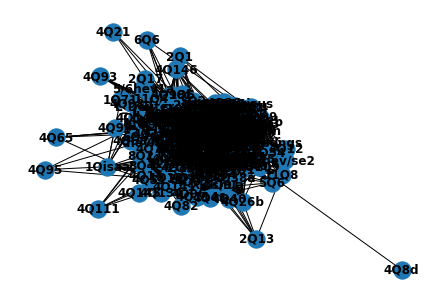

In [222]:
nx.draw(G, with_labels=True, font_weight='bold')

#nx.draw(G, with_labels=True)
plt.savefig('isagraph.png', dpi=300) #, bbox_inches='tight')

In [223]:
len(G.nodes)

251

In [224]:
G.degree

DegreeView({'4Q62': 84, '4Q99': 88, 'Mas1b': 138, '4Q84': 160, '1Q10': 26, '4Q97': 18, '4Q146': 12, '4Q83': 114, '4Q55': 135, '4Q139': 77, '4Q41': 37, '4Q137': 110, '4Q25': 138, '4Q38b': 100, '4Q76': 155, '4Q128': 116, '4Q26c': 127, 'L_Habakkuk': 161, '4Q27': 88, '4Q73': 113, '1Q4': 98, 'L_Proverbs': 105, '4Q77': 129, '4Q21': 3, '5Q5': 58, '4Q91': 49, '4Q29': 136, 'L_Daniel': 80, '4Q4': 152, '4Q141': 33, '1Q2': 61, '1Q3': 148, '4Q53': 92, 'L_Lamentations': 73, '4Q47': 142, '4Q72': 154, '4Q133': 125, 'Mas1c': 122, '4Q34': 86, '4Q56': 143, 'L_Nehemiah': 111, '4Q3': 127, '4Q40': 36, '4Q95': 4, '4Q14': 28, '4Q78': 127, '3Q2': 47, 'Xq3': 121, '11Q7': 112, '2Q14': 65, '4Q109': 86, '4Q48': 99, '4Q2': 126, '4Q33': 148, '3Q3': 63, 'L_Nahum': 145, '4Q90': 129, 'Mas1f': 134, '4Q144': 26, '4Q102': 145, '4Q96': 31, '5/6hev1a': 21, '4Q31': 156, '4Q58': 145, 'L_Hosea': 98, '4Q46': 76, '1Q13': 141, 'Xjudges': 100, '4Q149': 129, '4Q7': 130, 'L_Isaiah': 92, '4Q82': 21, '4Q15': 136, '4Q104': 63, '11Q2': 

In [225]:
def get_isa_values(data_dict, scrolls):
    return {k:v for k,v in data_dict.items() if k in scrolls}
        

In [226]:
deg_centrality = nx.degree_centrality(G)

pprint(deg_centrality)

{'11Q1': 0.496,
 '11Q2': 0.224,
 '11Q4': 0.124,
 '11Q5': 0.36,
 '11Q6': 0.448,
 '11Q7': 0.448,
 '11Q8': 0.088,
 '1Q1': 0.304,
 '1Q10': 0.10400000000000001,
 '1Q11': 0.168,
 '1Q13': 0.5640000000000001,
 '1Q2': 0.244,
 '1Q3': 0.592,
 '1Q4': 0.392,
 '1Q5': 0.616,
 '1Q6': 0.088,
 '1Q7': 0.216,
 '1Q71': 0.068,
 '1Q8': 0.316,
 '1Q9': 0.14400000000000002,
 '1Qisaa': 0.068,
 '2Q1': 0.044,
 '2Q13': 0.028,
 '2Q14': 0.26,
 '2Q16': 0.552,
 '2Q17': 0.052000000000000005,
 '2Q2': 0.504,
 '2Q3': 0.36,
 '2Q6': 0.22,
 '2Q7': 0.188,
 '34Se1': 0.492,
 '34Se2': 0.516,
 '3Q2': 0.188,
 '3Q3': 0.252,
 '4Q1': 0.596,
 '4Q10': 0.308,
 '4Q101': 0.192,
 '4Q102': 0.58,
 '4Q103': 0.46,
 '4Q104': 0.252,
 '4Q106': 0.492,
 '4Q107': 0.47600000000000003,
 '4Q109': 0.34400000000000003,
 '4Q11': 0.604,
 '4Q110': 0.3,
 '4Q111': 0.024,
 '4Q112': 0.548,
 '4Q113': 0.296,
 '4Q114': 0.10400000000000001,
 '4Q12': 0.112,
 '4Q128': 0.464,
 '4Q129': 0.38,
 '4Q13': 0.56,
 '4Q130': 0.528,
 '4Q131': 0.5760000000000001,
 '4Q132': 0.152,

In [227]:
get_isa_values(deg_centrality, nodes_isa)

{'4Q62': 0.336,
 '4Q99': 0.352,
 'Mas1b': 0.552,
 '4Q84': 0.64,
 '1Q10': 0.10400000000000001,
 '4Q97': 0.07200000000000001,
 '4Q146': 0.048,
 '4Q83': 0.456,
 '4Q55': 0.54,
 '4Q139': 0.308,
 '4Q41': 0.148,
 '4Q137': 0.44,
 '4Q25': 0.552,
 '4Q38b': 0.4,
 '4Q76': 0.62,
 '4Q128': 0.464,
 '4Q26c': 0.508,
 'L_Habakkuk': 0.644,
 '4Q27': 0.352,
 '4Q73': 0.452,
 '1Q4': 0.392,
 'L_Proverbs': 0.42,
 '4Q77': 0.516,
 '4Q21': 0.012,
 '5Q5': 0.232,
 '4Q91': 0.196,
 '4Q29': 0.544,
 'L_Daniel': 0.32,
 '4Q4': 0.608,
 '4Q141': 0.132,
 '1Q2': 0.244,
 '1Q3': 0.592,
 '4Q53': 0.368,
 'L_Lamentations': 0.292,
 '4Q47': 0.5680000000000001,
 '4Q72': 0.616,
 '4Q133': 0.5,
 'Mas1c': 0.488,
 '4Q34': 0.34400000000000003,
 '4Q56': 0.5720000000000001,
 'L_Nehemiah': 0.444,
 '4Q3': 0.508,
 '4Q40': 0.14400000000000002,
 '4Q95': 0.016,
 '4Q14': 0.112,
 '4Q78': 0.508,
 '3Q2': 0.188,
 'Xq3': 0.484,
 '11Q7': 0.448,
 '2Q14': 0.26,
 '4Q109': 0.34400000000000003,
 '4Q48': 0.396,
 '4Q2': 0.504,
 '4Q33': 0.592,
 '3Q3': 0.252,
 '

In [185]:
nx.clustering(G)

{'4Q62': 0.7578027465667915,
 '4Q99': 0.7837172243951905,
 'Mas1b': 0.7231807376734913,
 '4Q84': 0.6407441119581295,
 '1Q10': 0.796923076923077,
 '4Q97': 0.45751633986928103,
 '4Q146': 0.5757575757575758,
 '4Q83': 0.5522909777987719,
 '4Q55': 0.6725273080951668,
 '4Q139': 0.7467532467532467,
 '4Q41': 0.4152542372881356,
 '4Q137': 0.5904873752201997,
 '4Q25': 0.7755708343943638,
 '4Q38b': 0.8042424242424242,
 '4Q76': 0.7028423772609819,
 '4Q128': 0.6192601291837933,
 '4Q26c': 0.7890577507598784,
 'L_Habakkuk': 0.6290827052248372,
 '4Q27': 0.6192927787562661,
 '4Q73': 0.7375483870967742,
 '1Q4': 0.6798598227169655,
 'L_Proverbs': 0.5244510978043913,
 '4Q77': 0.877745155607751,
 '4Q21': 0.3333333333333333,
 '5Q5': 0.663036902601331,
 '4Q91': 0.6563265306122449,
 '4Q29': 0.7906037624347484,
 'L_Daniel': 0.5503198818897638,
 '4Q4': 0.7452099182868414,
 '4Q141': 0.6185383244206774,
 '1Q2': 0.6775214834916328,
 '1Q3': 0.7436290617013509,
 '4Q53': 0.6240913811007269,
 'L_Lamentations': 0.65943

In [186]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(G)
bet_cen

{'4Q62': 0.0016570179864822767,
 '4Q99': 0.0016608424555696675,
 'Mas1b': 0.002723207828689507,
 '4Q84': 0.004772960002067916,
 '1Q10': 4.1470125438515784e-05,
 '4Q97': 7.102502933871129e-05,
 '4Q146': 1.0676227107984392e-05,
 '4Q83': 0.0067338289691667285,
 '4Q55': 0.0032182165903301974,
 '4Q139': 0.00036806695793554237,
 '4Q41': 0.0013907290596052852,
 '4Q137': 0.0034519444380677,
 '4Q25': 0.001326048205127055,
 '4Q38b': 0.0007645083300121715,
 '4Q76': 0.0029226522820679575,
 '4Q128': 0.003888332692408799,
 '4Q26c': 0.001079960916973497,
 'L_Habakkuk': 0.005308676467312563,
 '4Q27': 0.0028779777405572673,
 '4Q73': 0.0016713410345769659,
 '1Q4': 0.0012869756706556518,
 'L_Proverbs': 0.011378616830774364,
 '4Q77': 0.00034937523452758216,
 '4Q21': 5.563483318581674e-07,
 '5Q5': 0.0004061285784850834,
 '4Q91': 0.0006040070285629628,
 '4Q29': 0.0013633642277619338,
 'L_Daniel': 0.004315605254818318,
 '4Q4': 0.0017023496356654369,
 '4Q141': 0.00021904021179226164,
 '1Q2': 0.000421999807123

In [187]:
get_isa_values(bet_cen, nodes_isa)

{'4Q62': 0.0016570179864822767,
 '4Q99': 0.0016608424555696675,
 'Mas1b': 0.002723207828689507,
 '4Q84': 0.004772960002067916,
 '1Q10': 4.1470125438515784e-05,
 '4Q97': 7.102502933871129e-05,
 '4Q146': 1.0676227107984392e-05,
 '4Q83': 0.0067338289691667285,
 '4Q55': 0.0032182165903301974,
 '4Q139': 0.00036806695793554237,
 '4Q41': 0.0013907290596052852,
 '4Q137': 0.0034519444380677,
 '4Q25': 0.001326048205127055,
 '4Q38b': 0.0007645083300121715,
 '4Q76': 0.0029226522820679575,
 '4Q128': 0.003888332692408799,
 '4Q26c': 0.001079960916973497,
 'L_Habakkuk': 0.005308676467312563,
 '4Q27': 0.0028779777405572673,
 '4Q73': 0.0016713410345769659,
 '1Q4': 0.0012869756706556518,
 'L_Proverbs': 0.011378616830774364,
 '4Q77': 0.00034937523452758216,
 '4Q21': 5.563483318581674e-07,
 '5Q5': 0.0004061285784850834,
 '4Q91': 0.0006040070285629628,
 '4Q29': 0.0013633642277619338,
 'L_Daniel': 0.004315605254818318,
 '4Q4': 0.0017023496356654369,
 '4Q141': 0.00021904021179226164,
 '1Q2': 0.000421999807123

In [188]:
# Closeness centrality
clo_cen = nx.closeness_centrality(G)
clo_cen

{'4Q62': 0.6082725060827251,
 '4Q99': 0.6527415143603134,
 'Mas1b': 0.7396449704142012,
 '4Q84': 0.8012820512820513,
 '1Q10': 0.5208333333333334,
 '4Q97': 0.5133470225872689,
 '4Q146': 0.5040322580645161,
 '4Q83': 0.704225352112676,
 '4Q55': 0.7440476190476191,
 '4Q139': 0.589622641509434,
 '4Q41': 0.5580357142857143,
 '4Q137': 0.6775067750677507,
 '4Q25': 0.7225433526011561,
 '4Q38b': 0.6218905472636815,
 '4Q76': 0.7598784194528876,
 '4Q128': 0.6775067750677507,
 '4Q26c': 0.6963788300835655,
 'L_Habakkuk': 0.8278145695364238,
 '4Q27': 0.6561679790026247,
 '4Q73': 0.6648936170212766,
 '1Q4': 0.6218905472636815,
 'L_Proverbs': 0.7530120481927711,
 '4Q77': 0.6666666666666666,
 '4Q21': 0.45955882352941174,
 '5Q5': 0.5643340857787811,
 '4Q91': 0.5494505494505495,
 '4Q29': 0.6983240223463687,
 'L_Daniel': 0.6684491978609626,
 '4Q4': 0.7552870090634441,
 '4Q141': 0.5319148936170213,
 '1Q2': 0.576036866359447,
 '1Q3': 0.746268656716418,
 '4Q53': 0.6361323155216285,
 'L_Lamentations': 0.730994

In [189]:
get_isa_values(clo_cen, isa_scrolls_final)

{'4Q62': 0.6082725060827251,
 '4Q55': 0.7440476190476191,
 '4Q56': 0.7911392405063291,
 '4Q58': 0.7861635220125787,
 'L_Isaiah': 0.7739938080495357,
 '1Q8': 0.7440476190476191,
 '4Q66': 0.5938242280285035,
 '1Qisaa': 0.4930966469428008,
 '4Q57': 0.6561679790026247,
 '4Q63': 0.5924170616113744,
 '4Q67': 0.5643340857787811,
 '4Q60': 0.6811989100817438,
 '4Q68': 0.5208333333333334,
 'Mur3': 0.6793478260869565,
 '4Q62a': 0.6925207756232687,
 '4Q64': 0.6738544474393531,
 '4Q61': 0.6906077348066298,
 '4Q59': 0.7204610951008645,
 '4Q65': 0.4699248120300752}

In [190]:
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(G)
eig_cen

{'4Q62': 0.04652633531640631,
 '4Q99': 0.06235800188182635,
 'Mas1b': 0.0829278352486725,
 '4Q84': 0.090984395491027,
 '1Q10': 0.013301903758013956,
 '4Q97': 0.009303957408149655,
 '4Q146': 0.005945751616594688,
 '4Q83': 0.06535976998579235,
 '4Q55': 0.08134768414405359,
 '4Q139': 0.038770400467150794,
 '4Q41': 0.01903083678175467,
 '4Q137': 0.05835777847516496,
 '4Q25': 0.08174626027327495,
 '4Q38b': 0.05408716806561578,
 '4Q76': 0.08689866009192249,
 '4Q128': 0.06044118646539404,
 '4Q26c': 0.07514777420735376,
 'L_Habakkuk': 0.0949207900852915,
 '4Q27': 0.056514825529501905,
 '4Q73': 0.06380186451211547,
 '1Q4': 0.04723171732489287,
 'L_Proverbs': 0.07548150515326488,
 '4Q77': 0.07337761008891303,
 '4Q21': 0.0015667332434421625,
 '5Q5': 0.02925663389520394,
 '4Q91': 0.02159000065182138,
 '4Q29': 0.07603202414683272,
 'L_Daniel': 0.05872416860851471,
 '4Q4': 0.08803360467356557,
 '4Q141': 0.012848778223687633,
 '1Q2': 0.03451667679059185,
 '1Q3': 0.08621922739451575,
 '4Q53': 0.049372

In [191]:
get_isa_values(eig_cen, isa_scrolls_final)

{'4Q62': 0.04652633531640631,
 '4Q55': 0.08134768414405359,
 '4Q56': 0.09161335693015354,
 '4Q58': 0.08826682707760183,
 'L_Isaiah': 0.08044777324802546,
 '1Q8': 0.07599647770719531,
 '4Q66': 0.04064746458949911,
 '1Qisaa': 0.007294430929204873,
 '4Q57': 0.05368552132585829,
 '4Q63': 0.042082786015712303,
 '4Q67': 0.029974005105134822,
 '4Q60': 0.0724154127637198,
 '4Q68': 0.01413750463533835,
 'Mur3': 0.07496429937947209,
 '4Q62a': 0.0760182185176168,
 '4Q64': 0.07407053258812518,
 '4Q61': 0.07551111986390163,
 '4Q59': 0.07717768559194685,
 '4Q65': 0.0021473041160543983}

In [228]:
page_rank = nx.pagerank(G, alpha = 0.85)

In [229]:
page_rank

{'4Q62': 0.003685749821026494,
 '4Q99': 0.0036988252051113626,
 'Mas1b': 0.005424970239741008,
 '4Q84': 0.00627541468937589,
 '1Q10': 0.0015502504468387407,
 '4Q97': 0.0013193841727391488,
 '4Q146': 0.0010455460263861169,
 '4Q83': 0.004745957864741654,
 '4Q55': 0.005384800606113528,
 '4Q139': 0.0034154985849213252,
 '4Q41': 0.0020999661037506626,
 '4Q137': 0.004608404453908751,
 '4Q25': 0.005376528709014835,
 '4Q38b': 0.004237731323194183,
 '4Q76': 0.006049108391142149,
 '4Q128': 0.004814524900076155,
 '4Q26c': 0.004976724434361635,
 'L_Habakkuk': 0.006298447357914716,
 '4Q27': 0.003789428875757671,
 '4Q73': 0.0046537521598887365,
 '1Q4': 0.00423186954323512,
 'L_Proverbs': 0.004830946987195413,
 '4Q77': 0.005074551784245212,
 '4Q21': 0.0007144610273238448,
 '5Q5': 0.002784808091981578,
 '4Q91': 0.0024998498586207354,
 '4Q29': 0.005319916266595122,
 'L_Daniel': 0.0036387560351054692,
 '4Q4': 0.0058584682722302005,
 '4Q141': 0.0018999444229593234,
 '1Q2': 0.002837673685839587,
 '1Q3': 0

In [152]:
get_isa_values(page_rank, isa_scrolls_final)

{'4Q62': 0.052425719094332926,
 '4Q68': 0.02416269567960313,
 '1Q8': 0.07073218058903301,
 '4Q66': 0.024245010316688284,
 '1Qisaa': 0.01929114153186908,
 '4Q55': 0.08307703556663552,
 '4Q57': 0.06210463020745652,
 'Mur3': 0.05953861516154636,
 '4Q63': 0.04797897328332931,
 '4Q62a': 0.05953861516154636,
 '4Q56': 0.07628670297520834,
 '4Q64': 0.05953861516154636,
 '4Q61': 0.054049117706023275,
 '4Q65': 0.013906748386319709,
 '4Q59': 0.053690845814816104,
 '4Q58': 0.08333270143670761,
 '4Q67': 0.029457003566860204,
 'L_Isaiah': 0.06745049609838702,
 '4Q60': 0.05919315226209075}

In [230]:
G.nodes

NodeView(('4Q62', '4Q99', 'Mas1b', '4Q84', '1Q10', '4Q97', '4Q146', '4Q83', '4Q55', '4Q139', '4Q41', '4Q137', '4Q25', '4Q38b', '4Q76', '4Q128', '4Q26c', 'L_Habakkuk', '4Q27', '4Q73', '1Q4', 'L_Proverbs', '4Q77', '4Q21', '5Q5', '4Q91', '4Q29', 'L_Daniel', '4Q4', '4Q141', '1Q2', '1Q3', '4Q53', 'L_Lamentations', '4Q47', '4Q72', '4Q133', 'Mas1c', '4Q34', '4Q56', 'L_Nehemiah', '4Q3', '4Q40', '4Q95', '4Q14', '4Q78', '3Q2', 'Xq3', '11Q7', '2Q14', '4Q109', '4Q48', '4Q2', '4Q33', '3Q3', 'L_Nahum', '4Q90', 'Mas1f', '4Q144', '4Q102', '4Q96', '5/6hev1a', '4Q31', '4Q58', 'L_Hosea', '4Q46', '1Q13', 'Xjudges', '4Q149', '4Q7', 'L_Isaiah', '4Q82', '4Q15', '4Q104', '11Q2', 'L_2_Kings', '1Q6', '4Q28', 'Xhev/se3', '1Q8', 'Xq1', 'L_Job', '4Q113', '4Q66', '1Qisaa', '4Q138', '4Q129', '4Q22', '5Q2', 'L_Deuteronomy', 'L_2_Samuel', '4Q150', '4Q12', '4Q98d', '6Q1', '4Q57', '2Q13', '5Q1', '8Q3', '4Q151', '2Q3', 'L_Jeremiah', '2Q2', '4Q51', 'L_Leviticus', '4Q63', '4Q98g', '4Q131', 'L_Ruth', '11Q5', '4Q45', '6Q4', 

In [231]:
import community

partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]
counter=collections.Counter(values)
print(counter)

Counter({1: 93, 0: 86, 2: 72})


In [232]:
nodes

['4Q62',
 '5Q3',
 '4Q69',
 '4Q68',
 '1Q8',
 '4Q66',
 '1Qisaa',
 '4Q55',
 '4Q69a',
 '4Q57',
 'Mur3',
 '4Q63',
 '4Q62a',
 '4Q56',
 '4Q64',
 '4Q61',
 '4Q69b',
 '4Q65',
 '4Q59',
 '4Q58',
 '4Q67',
 'L_Isaiah',
 '4Q60']

In [233]:
{n:v for n, v in zip(nodes, values)}

{'4Q62': 2,
 '5Q3': 1,
 '4Q69': 1,
 '4Q68': 1,
 '1Q8': 0,
 '4Q66': 0,
 '1Qisaa': 0,
 '4Q55': 2,
 '4Q69a': 2,
 '4Q57': 2,
 'Mur3': 2,
 '4Q63': 2,
 '4Q62a': 1,
 '4Q56': 0,
 '4Q64': 1,
 '4Q61': 2,
 '4Q69b': 1,
 '4Q65': 2,
 '4Q59': 2,
 '4Q58': 2,
 '4Q67': 2,
 'L_Isaiah': 0,
 '4Q60': 1}

In [212]:
triangles = nx.triangles(G)
sorted(triangles.items(), key=lambda x:x[1], reverse=True)

[('L_Habakkuk', 10466),
 ('L_Joel', 9425),
 ('L_Haggai', 9342),
 ('5/6hev1b', 9158),
 ('Mas1d', 9045),
 ('4Q32', 9043),
 ('4Q35', 8877),
 ('Xq1', 8860),
 ('4Q84', 8839),
 ('4Q24', 8751),
 ('4Q44', 8724),
 ('4Q4', 8711),
 ('4Q76', 8668),
 ('4Q31', 8655),
 ('Mas1e', 8637),
 ('4Q42', 8566),
 ('4Q33', 8557),
 ('4Q136', 8537),
 ('1Q3', 8528),
 ('1Q5', 8445),
 ('L_Amos', 8411),
 ('5Q1', 8403),
 ('4Q11', 8389),
 ('L_Nahum', 8320),
 ('4Q52', 8274),
 ('4Q1', 8272),
 ('L_Zephaniah', 8236),
 ('4Q56', 8126),
 ('Xq2', 8118),
 ('4Q45', 8097),
 ('L_Ruth', 8035),
 ('Mur1', 8007),
 ('4Q58', 7950),
 ('4Q150', 7887),
 ('4Q131', 7815),
 ('4Q25', 7781),
 ('4Q72', 7722),
 ('1Q13', 7680),
 ('4Q112', 7628),
 ('4Q47', 7591),
 ('4Q102', 7554),
 ('4Q86', 7531),
 ('4Q88', 7490),
 ('4Q13', 7443),
 ('4Q30', 7426),
 ('4Q17', 7397),
 ('4Q9', 7396),
 ('Mur4', 7168),
 ('4Q29', 7149),
 ('Mas1b', 7040),
 ('2Q16', 6993),
 ('4Q72a', 6984),
 ('4Q15', 6948),
 ('4Q152', 6948),
 ('L_Micah', 6933),
 ('4Q62a', 6931),
 ('4Q61', 6

In [197]:
nx.transitivity(G)

0.6919596035420302

In [198]:
nx.average_clustering(G)

0.6732530019299612

In [199]:
nx.density(G)

0.4561593625498008